# Sprint Seq2Seq

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [30]:
from __future__ import print_function

from  keras.models import Model
from keras.layers import Input , LSTM , Dense
from keras.callbacks import EarlyStopping 

Using TensorFlow backend.


In [0]:
! http://www.manythings.org/anki/fra-eng.zip

/bin/bash: http://www.manythings.org/anki/fra-eng.zip: No such file or directory


In [0]:
! http://www.manythings.org/anki/

/bin/bash: http://www.manythings.org/anki/: No such file or directory


In [0]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [0]:
# ハイパーパラメーター
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000
data_path = "/content/fra.txt"

In [0]:
# データのベクトル化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

#データファイルの読み込み
with open(data_path , "r" , encoding="utf-8") as f:
  lines = f.read().split("\n") #改行で文字列を分割している
#データの前処理
for line in lines[: min(num_samples , len(lines) - 1)]:
  input_text , target_text , _ = line.split("\t")
  target_text = "\t" + target_text + "\n"
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)
    
input_characters = sorted(list(input_characters)) #文字を順番に並べる
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) #文字の数
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])#txtの中の最大数の文字
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [0]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_dataはdecoder_input_dataより1タイムステップだけ進んでいます
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decode_target_dataは1タイムステップ先になります
            # 開始文字は含まれません。
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# 入力シーケンスを定義して処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 「encoder_outputs」を破棄し、状態のみを保持します。
encoder_states = [state_h, state_c]

In [0]:
# 初期状態として「encoder_states」を使用して、デコーダーをセットアップします。
decoder_inputs = Input(shape=(None, num_decoder_tokens))
#完全な出力シーケンスを返すようにデコーダを設定し、
#また、内部状態も返します。
#トレーニングモデルでは戻り状態を使用しませんが、推論では使用します。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#回転するモデルを定義する
#「encoder_input_data」と「decoder_input_data」を「decoder_target_data」に
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
early_stopping = EarlyStopping(monitor="val_loss", patience=10) 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[early_stopping])
# Save model
model.save('s2s.h5')

#次：推論モード（サンプリング）。
#ドリルは次のとおりです。
#1）入力をエンコードし、初期デコーダー状態を取得する
#2）この初期状態でデコーダーの1ステップを実行する
#およびターゲットとしての「シーケンスの開始」トークン。
#出力は次のターゲットトークンになります
#3）現在のターゲットトークンと現在の状態で繰り返します

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8000 samples, validate on 2000 samples
Epoch 1/100





8000/8000 [==============================] - 25s 3ms/step - loss: 1.1938 - acc: 0.7237 - val_loss: 1.2909 - val_acc: 0.7177
Epoch 2/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.8676 - acc: 0.7658 - val_loss: 0.8766 - val_acc: 0.7603
Epoch 3/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.6900 - acc: 0.8063 - val_loss: 0.7359 - val_acc: 0.7900
Epoch 4/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5997 - acc: 0.8257 - val_loss: 0.6608 - val_acc: 0.8075
Epoch 5/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5496 - acc: 0.8387 - val_loss: 0.6165 - val_acc: 0.8198
Epoch 6/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5126 - acc: 0.8493 - val_loss: 0.5841 - val_acc: 0.8275
Epoch 7/100
8000/8000 [=========

# 【問題2】イメージキャプショニングの学習済みモデルの実行

http://cedro3.com/ai/pytorch-image-captioning/

In [12]:
!pip uninstall torch

Uninstalling torch-0.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/torch-0.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torch/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/torch/__config__.py
    /usr/local/lib/python3.6/dist-packages/torch/__future__.py
    /usr/local/lib/python3.6/dist-packages/torch/__init__.pyi
    /usr/local/lib/python3.6/dist-packages/torch/_classes.py
    /usr/local/lib/python3.6/dist-packages/torch/_jit_internal.py
    /usr/local/lib/python3.6/dist-packages/torch/_namedtensor_internals.py
    /usr/local/lib/python3.6/dist-packages/torch/_ops.py
    /usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.pyi
    /usr/local/lib/python3.6/dist-packages/torch/autograd/grad_mode.pyi
    /usr/local/lib/python3.6/dist-packages/torch/backends/mkldnn/__init__.py
    /usr/local/lib/python3.6/dist-packages/torch/backends/openmp/__init__.py
    /usr/local/lib/python3.6/dist-packages/torch/b

In [19]:
!pip install torch==0.4.1

In [20]:
!pip install torchvision==0.2.1

In [0]:
#pytorchのバージョンを0.4.1へ　https://pytorch.org/get-started/previous-versions/
#torchvisionをインストール　conda install pytorch torchvision
import torch

In [2]:
print(torch.__version__) 

0.4.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
cd content

/content


In [12]:
!git clone https://github.com/pdollar/coco.git

fatal: destination path 'coco' already exists and is not an empty directory.


In [13]:
!pwd

/content


In [14]:
cd /content/coco/PythonAPI/

/content/coco/PythonAPI


In [15]:
pwd

'/content/coco/PythonAPI'

In [16]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [17]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [18]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__

In [19]:
cd ../../

/content


In [20]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 816, done.
remote: Total 816 (delta 0), reused 0 (delta 0), pack-reused 816
Receiving objects: 100% (816/816), 12.78 MiB | 6.39 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [21]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [22]:
pwd

'/content/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [23]:
!pip install -r requirements.txt

In [24]:
!https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

/bin/bash: https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0: No such file or directory


In [25]:
!https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

/bin/bash: https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0: No such file or directory


In [27]:
!python sample.py --image=png/example.png

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100% 241530880/241530880 [00:10<00:00, 23687148.57it/s]
<start> a group of giraffes standing next to each other . <end>


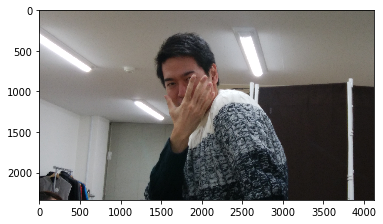

<start> a man is holding a cell phone in front of a window . <end>


In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main():
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    plt.show()
    print (sentence)
    
if __name__ == '__main__':
    encoder_path ='models/encoder-2-1000.ckpt'
    decoder_path ='models/decoder-2-1000.ckpt'
    vocab_path ='data/vocab.pkl'
    
    # Model parameters (should be same as paramters in train.py)
    embed_size=256
    hidden_size=512
    num_layers=1
    
    import glob
    files = sorted(glob.glob('img/*.jpg'))
    for i, image_path in enumerate (files):   
        main()

# 【問題3】Kerasで動かしたい場合はどうするかを調査

MMdnnを使用する

https://github.com/Microsoft/MMdnn

Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール。
中間表現を経由することで様々なフレームワーク間でのモデルデータの相互変換を実現しています。

https://qiita.com/koppe/items/7f85f5411539390c4499

以下のフレームワークでモデルの相互運用が可能
Caffe、Keras、Tensorflow、CNTK、MXNet、PyTorch、CoreML

mmconvert -sf pytorch -iw imagenet_inception_v3.h5 -df keras -om imagenet_inception_v3.onnx